In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import median_absolute_deviation, iqr
import pandas as pd
import statistics
from sklearn.neighbors import KernelDensity
import scipy.optimize as optimize

In [42]:
N = 1000
d1 = np.random.normal(loc = 1.0, scale = 1.0, size = N) # N(0, 1)
d2 = np.random.normal(loc = 2.0, scale = 1.0, size = N) # N(2, 1)

In [43]:
def calc_Silverman_bandwidth(data):
    IQR = iqr(data)
    s = statistics.stdev(data)
    s_star = min(s, IQR)
    N = len(data)
    h = 0.9*s_star*np.power(N, -0.2)
    return h

In [44]:
def generate_models(d1, d2, band1, band2):
    # test_data = np.linspace(np.min(d1), np.max(d1), 1000)# Test Data Set
    pdf1 = KernelDensity(bandwidth=band1, kernel='gaussian')
    pdf1.fit(d1[:, None]) # (n, 1)

    pdf2 = KernelDensity(bandwidth=band2, kernel='gaussian')
    pdf2.fit(d2[:, None]) # (n, 1)
    return pdf1, pdf2

def generate_inital_theta(pdf1, pdf2, N):
    mean_1 = np.mean(pdf1.sample(N))
    mean_2 = np.mean(pdf2.sample(N))
    w = mean_1/mean_2
    b = mean_1 - w * mean_2
    return np.array([w, b])

In [45]:
band1 = calc_Silverman_bandwidth(d1)
band2 = calc_Silverman_bandwidth(d2)
pdf1, pdf2 = generate_models(d1, d2, band1, band2)

(1000,)


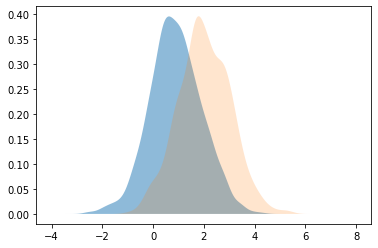

In [46]:
Wafer_Test = np.linspace(-4, 8, 1000)# Test Data Set

logprob1 = pdf1.score_samples(Wafer_Test[:, None])
logprob2 = pdf2.score_samples(Wafer_Test[:, None])
plt.fill_between(Wafer_Test, np.exp(logprob1), alpha=0.5)
plt.fill_between(Wafer_Test, np.exp(logprob2), alpha=0.2)
print(np.shape(np.exp(logprob1)))

In [97]:
def opt_function(x):
    t_data = Wafer_Test[:, None]
    res1 = np.exp(pdf1.score_samples(t_data))
    res2 = np.exp(pdf1.score_samples(t_data*x[0]+x[1]))
    return sum(abs(res1 - res2))

In [98]:
x0 = [1, 1]
x0

[1, 1]

In [99]:
res = optimize.minimize(opt_function, x0, method='nelder-mead',options={'xatol': 1e-10, 'disp': True})
res.x

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 91
         Function evaluations: 175


array([1.00000000e+00, 3.10258465e-11])

In [91]:
opt_function(res.x)

1.75800409894736e-09

(1000,)


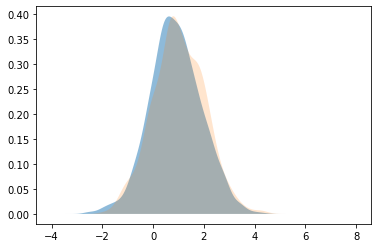

In [93]:
logprob1 = pdf1.score_samples(Wafer_Test[:, None])
# logprob2 = pdf2.score_samples(Wafer_Test[:, None]*res.x[0]+ res.x[1])
logprob2 = pdf2.score_samples(Wafer_Test[:, None]*1+ 1)
plt.fill_between(Wafer_Test, np.exp(logprob1), alpha=0.5)
plt.fill_between(Wafer_Test, np.exp(logprob2), alpha=0.2)
print(np.shape(np.exp(logprob1)))

In [94]:
opt_function([1,1])

63.27440630720973

In [69]:
tt = np.array([[1] ,[2]])
r1 = np.exp(pdf1.score_samples(tt))
r1

array([0.37955055, 0.20373722])

In [88]:
r2 = np.exp(pdf2.score_samples(tt+0))
r2

array([0.23727232, 0.38005989])

In [89]:
tt + 1

array([[2],
       [3]])

In [90]:
sum(abs(r1 - r2))

0.3186008952751843